# 4X Study Dashboard
This notebook is used to analyze data from the 4X study conducted in March 2018.

# Imports and Global Setup

In [1]:
import json
from functools import reduce
from collections import Counter

import requests
import pandas as pd
import numpy as np

from datetime import datetime, timezone
from copy import deepcopy
from tqdm import *

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

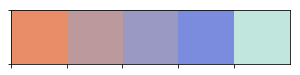

In [3]:
# defining colors
COLORS = {
    'ORANGE': '#E88D67',
    'PINK': '#BB999C',
    'VIOLET': '#9999C3',
    'BLUE': '#7B8CDE',
    'GREEN': '#C0E6DE'
}

# palette
sns.set_palette(COLORS.values())
sns.palplot(sns.color_palette())
sns.set(font_scale=1.5, style='whitegrid')

# Load in data

In [4]:
# URLs for different conditions
url_4x = 'https://les-4x.herokuapp.com/parse/classes/'
url_opp_location = 'https://les-opplocation.herokuapp.com/parse/classes/'
url_opp_distance = 'https://les-oppdistance.herokuapp.com/parse/classes/'

# shared header and data
header = {'X-Parse-Application-Id': 'PkngqKtJygU9WiQ1GXM9eC0a17tKmioKKmpWftYr'}
data = {'limit': '10000'}

# study start and end
start_time = '2018-03-05 06:00:00'
end_time = '2018-03-19 05:00:00'
print('Study Length: {}'.format(datetime.strptime(end_time, '%Y-%m-%d %H:%M:%S') - datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')))

Study Length: 13 days, 23:00:00


In [5]:
def load_data(base_url, header, data, start_time, end_time):
    """
    Loads in all needed tables from database, given url.
    
    Input: 
        base_url (string): url to pull data from
        header (dict): application id and other auth
        data (dict): data to pass into query
        start_time (datetime): start time for data
        end_time (datetime): end time for data 
    
    Return:
        (dict): dict where keys are collection names and values are Pandas objects containing data
    """
    # declare collection list
    collection_list = ['_User', 'ServerLog', 'DebugLog', 'ForYouViewLog', 'ApplicationHeartbeat',
                       'TaskLocations', 'LocationTypeMetadata', 'beacons', 'EnRouteLocations',
                       'AtLocationNotificationsSent', 'AtLocationNotificationResponses',
                       'EnRouteNotificationsSent', 'EnRouteNotificationResponses',
                       'AtDistanceNotificationsSent', 'AtDistanceNotificationResponses']
    
    # loop through and load data for each collection
    output = {}
    for collection in tqdm(collection_list):
        current_response = requests.get(base_url + collection, headers=header, data=data)

        current_data = pd.DataFrame(current_response.json()['results'])
        if len(current_data) != 0 and collection not in ['LocationTypeMetadata', 'EnRouteLocations']:
            current_data['createdAt'] = pd.to_datetime(current_data['createdAt'])
            current_data['updatedAt'] = pd.to_datetime(current_data['updatedAt'])
            
            if collection != '_User':
                current_data = current_data[(current_data['createdAt'] >= start_time) & (current_data['createdAt'] < end_time)]

        output[collection] = current_data
    
    return output

In [6]:
data_4x = load_data(url_4x, header, data, start_time, end_time)

100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


In [7]:
data_opp_loc = load_data(url_opp_location, header, data, start_time, end_time)

100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


In [8]:
data_opp_dist = load_data(url_opp_distance, header, data, start_time, end_time)

100%|██████████| 15/15 [00:04<00:00,  3.46it/s]


# Data Setup
This section of the notebook is used to monitor the data coming in from the study. Some measures we see here may be used within the paper

## Common Functions and Data

In [9]:
def get_merged_at_location(tasklocations, atlocnotif, atlocresp):
    """
    Sets up a Pandas DataFrame with (1) TaskLocation, (2) NotificationSent, and (3) NotificationResponse data
    merged together for AtLocation case.
    
    Input:
        tasklocations (DataFrame): DataFrame of TaskLocations
        atlocnotif (DataFrame): DataFrame of AtLocationNotificationsSent
        atlocresp (DataFrame): DataFrame of AtLocationNotificationResponses
    
    Return:
        (DataFrame): merged DataFrame of inputs
    """
    # get AtLocationNotifications without duplicates
    atlocnotif.drop_duplicates(subset=['taskLocationId', 'vendorId'], keep='last', inplace=True)
    atlocnotif.drop(['objectId', 'createdAt', 'updatedAt'], axis=1, inplace=True)

    # get AtLocationNotificationResponses without duplicates
    atlocresp.drop_duplicates(subset=['taskLocationId', 'vendorId'], keep='last', inplace=True)
    atlocresp.drop(['objectId', 'createdAt', 'updatedAt'], axis=1, inplace=True)
    
    # combine AtLocation notifications and responses, with some data from TaskLocations
    atloc = atlocnotif.merge(tasklocations[['objectId', 'locationType', 'locationName', 'beaconId']],
                             how='inner', left_on='taskLocationId', right_on='objectId')
    atloc = atloc.merge(atlocresp[['question', 'response', 'timestamp', 'taskLocationId', 'vendorId']],
                        how='left', on=['taskLocationId', 'vendorId'])
    
    # clean columns
    del atloc['objectId']
    atloc.rename(columns={'timestamp_x': 'notificationTimestamp', 'timestamp_y': 'responseTimestamp'},
                 inplace=True)
    
    # fill blank columns
    atloc[['question', 'response']] = atloc[['question', 'response']].fillna(value='missed notification')
    atloc[['distanceToLocation', 'responseTimestamp']] = atloc[['distanceToLocation', 'responseTimestamp']].fillna(value=-1)

    # type columns
    atloc_int_cols = ['gmtOffset','notificationTimestamp', 'responseTimestamp']
    atloc[atloc_int_cols] = atloc[atloc_int_cols].apply(lambda x: x.astype(np.int64))
    
    # add remappedResponses column 
    invalid_responses = ['I don\'t know', 'com.apple.UNNotificationDismissActionIdentifier', 'missed notification']
    atloc['remappedResponses'] = atloc['response']
    atloc.loc[~atloc['remappedResponses'].isin(invalid_responses), 'remappedResponses'] = 'valid response'
    atloc.loc[atloc['remappedResponses'] == 'com.apple.UNNotificationDismissActionIdentifier', 'remappedResponses'] = 'dismissed notification'
    
    # reorder columns
    atloc_col_ordering = ['taskLocationId', 'vendorId', 'beaconId', 'distanceToLocation',
                          'locationType', 'locationName','gmtOffset', 'notificationTimestamp', 'notificationString',
                          'question', 'response', 'remappedResponses', 'responseTimestamp']
    atloc = atloc[atloc_col_ordering]
    
    return atloc

In [10]:
def get_merged_at_distance(tasklocations, atdistnotif, atdistresp):
    """
    Sets up a Pandas DataFrame with (1) TaskLocation, (2) NotificationSent, and (3) NotificationResponse data
    merged together for AtDistance case.
    
    Input:
        tasklocations (DataFrame): DataFrame of TaskLocations
        atdistnotif (DataFrame): DataFrame of AtDistanceNotificationsSent
        atdistresp (DataFrame): DataFrame of AtDistanceNotificationResponses
    
    Return:
        (DataFrame): merged DataFrame of inputs
    """
    # get AtDistanceNotifications without duplicates
    atdistnotif.drop_duplicates(subset=['taskLocationId', 'vendorId'], keep='last', inplace=True)
    atdistnotif.drop(['objectId', 'createdAt', 'updatedAt'], axis=1, inplace=True)

    # get AtDistanceNotificationResponses without duplicates
    atdistresp.drop_duplicates(subset=['taskLocationId', 'vendorId'], keep='last', inplace=True)
    atdistresp.drop(['objectId', 'createdAt', 'updatedAt'], axis=1, inplace=True)
    
    # combine AtDistance notifications and responses, with some data from TaskLocations
    atdist = atdistnotif.merge(tasklocations[['objectId', 'beaconId', 'locationName']],
                               how='inner', left_on='taskLocationId', right_on='objectId')
    atdist = atdist.merge(atdistresp[['emaResponse', 'timestamp', 'taskLocationId', 'vendorId']],
                          how='left', on=['taskLocationId', 'vendorId'])
    
    # clean columns
    del atdist['objectId']
    atdist.rename(columns={'timestamp_x': 'notificationTimestamp', 'timestamp_y': 'responseTimestamp'}, inplace=True)

    atdist_col_ordering = ['taskLocationId', 'vendorId', 'beaconId', 'distanceToLocation', 'bearingToLocation',
                           'locationType', 'locationName', 'notificationDistance', 'sentBy', 'infoIncluded',
                           'gmtOffset', 'notificationTimestamp', 'emaResponse', 'responseTimestamp']
    atdist = atdist[atdist_col_ordering]
    
    # fill blank columns
    atdist['emaResponse'] = atdist['emaResponse'].fillna(value='missed notification')
    atdist.loc[atdist['emaResponse'] == 'com.apple.UNNotificationDismissActionIdentifier', 'emaResponse'] = 'dismissed notification'
    
    atdist['responseTimestamp'] = atdist['responseTimestamp'].fillna(value=-1)

    # type columns
    atdist_int_cols = ['gmtOffset','notificationTimestamp', 'responseTimestamp']
    atdist[atdist_int_cols] = atdist[atdist_int_cols].apply(lambda x: x.astype(np.int64))
    
    return atdist

In [11]:
def get_merged_en_route(enroutelocations, enroutenotif, enrouteresp):
    """
    Sets up a Pandas DataFrame with (1) EnRouteLocations, (2) NotificationSent, and (3) NotificationResponse data
    merged together for EnRoute case.
    
    Input:
        enroutelocations (DataFrame): DataFrame of EnRouteLocations
        enroutenotif (DataFrame): DataFrame of EnRouteNotificationsSent
        enrouteresp (DataFrame): DataFrame of EnRouteNotificationResponses
    
    Return:
        (DataFrame): merged DataFrame of inputs
    """
    # get EnRouteNotifications without duplicates
    enroutenotif.drop_duplicates(subset=['enRouteLocationId', 'vendorId'], keep='last', inplace=True)
    enroutenotif.drop(['objectId', 'createdAt', 'updatedAt'], axis=1, inplace=True)

    # get AtDistanceNotificationResponses without duplicates
    enrouteresp.drop_duplicates(subset=['enRouteLocationId', 'vendorId'], keep='last', inplace=True)
    enrouteresp.drop(['objectId', 'createdAt', 'updatedAt'], axis=1, inplace=True)
    
    # combine EnRouteNotifications and responses, with some data from EnRouteLocations
    enroute = enroutenotif.merge(enroutelocations[['objectId', 'locationName', 'locationType']],
                               how='inner', left_on='enRouteLocationId', right_on='objectId')
    enroute = enroute.merge(enrouteresp[['questionResponse', 'timestamp', 'enRouteLocationId', 'vendorId']],
                            how='left', on=['enRouteLocationId', 'vendorId'])
    
    # clean columns
    del enroute['objectId']
    enroute.rename(columns={'timestamp_x': 'notificationTimestamp', 'timestamp_y': 'responseTimestamp'}, inplace=True)

    enroute_col_ordering = ['enRouteLocationId', 'vendorId', 'distanceToLocation', 'locationType', 'locationName',
                           'gmtOffset', 'notificationTimestamp', 'questionResponse', 'responseTimestamp']
    enroute = enroute[enroute_col_ordering]
    
    # fill blank columns
    enroute['questionResponse'] = enroute['questionResponse'].fillna(value='missed notification')
    enroute.loc[enroute['questionResponse'] == 'com.apple.UNNotificationDismissActionIdentifier', 'questionResponse'] = 'dismissed notification'
    
    enroute['responseTimestamp'] = enroute['responseTimestamp'].fillna(value=-1)
    
     # add validResponse column 
    invalid_responses = ['I don\'t know', 'com.apple.UNNotificationDismissActionIdentifier', 'missed notification']
    enroute['remappedResponses'] = enroute['questionResponse']
    enroute.loc[~enroute['remappedResponses'].isin(invalid_responses), 'remappedResponses'] = 'valid response'
    enroute.loc[enroute['remappedResponses'] == 'com.apple.UNNotificationDismissActionIdentifier', 'remappedResponses'] = 'dismissed notification'

    # type columns
    enroute_int_cols = ['gmtOffset','notificationTimestamp', 'responseTimestamp']
    enroute[enroute_int_cols] = enroute[enroute_int_cols].apply(lambda x: x.astype(np.int64))
    
    return enroute

In [12]:
def get_dead_apps(serverlog):
    """
    Returns a list of lists for dead apps that server has notified.
    
    Input: 
        server (DataFrame): DataFrame of ServerLog
    
    Return:
        (list of lists of strings): all dead applications notified via push
    """
    notify_log_strings = serverlog[serverlog['logString'].str.contains('Notified dead')]['logString']
    deadapp_notif_list = list(notify_log_strings.apply(lambda x: x[x.find('[') + 1:-1].split(', ')))
    return deadapp_notif_list

In [13]:
location_scaffolds = {}
for index, row in data_4x['LocationTypeMetadata'].iterrows():
    location_scaffolds[row['locationType']] = row['scaffold']
location_scaffolds

{'coffeeshop': {'privateseating': '',
  'privateseatingoutlets': '',
  'privateseatingwindows': '',
  'sharedseating': '',
  'sharedseatingoutlets': '',
  'sharedseatingwindows': ''},
 'freefood': {'foodtype': '', 'stillleft': ''},
 'gym': {'ellipticals': '',
  'freeweights': '',
  'freeweightsbenches': '',
  'freeweightssquatracks': '',
  'stretch': '',
  'stretchmats': '',
  'stretchrollers': '',
  'treadmills': ''},
 'workspace': {'privateseating': '',
  'privateseatingoutlets': '',
  'sharedseating': '',
  'sharedseatingoutlets': '',
  'whiteboards': '',
  'whiteboardsmarkers': ''}}

## 4X Data Setup

In [14]:
users_4x = deepcopy(data_4x['_User'])
users_4x = users_4x[users_4x['vendorId'] != '']

In [15]:
serverlog_4x = deepcopy(data_4x['ServerLog'])
deadapp_notify_4x = get_dead_apps(serverlog_4x)
print('Last dead apps notified (count = {}): \n{}'.format(len(deadapp_notify_4x[-1]),
                                                          '\n'.join(deadapp_notify_4x[-1])))

flattened_deadapps_4x = reduce(lambda x, y: x + y, deadapp_notify_4x, [])
Counter(flattened_deadapps_4x)

Last dead apps notified (count = 16): 
B58B0DF7-8DA5-4A22-98EF-2AE712D4DB10
4B4115BA-BF8C-4F05-9B6E-7862FA08FC5F
F57CB6D4-09B3-4796-AE91-2F31BADEE832
79CCD350-AAC5-4586-A6FC-1948B49A4B10
A0288977-976D-4831-93D4-8472FC842621
95674A2B-6954-49C6-9456-A7F865CE686E
437A2325-CA4D-4426-9F1A-F89E412A00AC
E89FDDC1-0ADA-4249-B9AD-40F24FD9DE30
4D412B42-A080-49E7-A091-74C42D2778BF
6E3825DB-09C2-4C6C-B3BC-62DBFFD6F7EE
B0686F52-978C-4925-A466-E7A6A765B258
53F61BDE-FFC0-476A-AF7B-D592F4155AC8
D3D3D1E2-1F39-4AB8-917D-52876AA63830
E78771C1-08B3-4483-99D8-4A081E98DABC
C89DDEDC-F459-40BA-8073-EAFF7FC53C34
FDEFE367-350F-4B8B-898E-710487D51BF4


Counter({'0EC5DDE3-5D78-4025-AC41-EF6EEF9612FC': 1,
         '203FE158-68A6-496F-B72E-274A4417983A': 2,
         '437A2325-CA4D-4426-9F1A-F89E412A00AC': 2,
         '4B4115BA-BF8C-4F05-9B6E-7862FA08FC5F': 4,
         '4D412B42-A080-49E7-A091-74C42D2778BF': 1,
         '4DFAD945-87C6-4219-B237-7345E7600105': 2,
         '53F61BDE-FFC0-476A-AF7B-D592F4155AC8': 4,
         '6E3825DB-09C2-4C6C-B3BC-62DBFFD6F7EE': 1,
         '79CCD350-AAC5-4586-A6FC-1948B49A4B10': 4,
         '8617CA10-E2AD-4420-B92B-AF170930FDB1': 2,
         '95674A2B-6954-49C6-9456-A7F865CE686E': 4,
         'A0288977-976D-4831-93D4-8472FC842621': 1,
         'B0686F52-978C-4925-A466-E7A6A765B258': 4,
         'B58B0DF7-8DA5-4A22-98EF-2AE712D4DB10': 4,
         'C89DDEDC-F459-40BA-8073-EAFF7FC53C34': 4,
         'D3D3D1E2-1F39-4AB8-917D-52876AA63830': 4,
         'E78771C1-08B3-4483-99D8-4A081E98DABC': 4,
         'E89FDDC1-0ADA-4249-B9AD-40F24FD9DE30': 4,
         'F57CB6D4-09B3-4796-AE91-2F31BADEE832': 3,
         'F8

In [16]:
tasklocations_4x = deepcopy(data_4x['TaskLocations'])
enroutelocations_4x = deepcopy(data_4x['EnRouteLocations'])

atlocnotif_4x = deepcopy(data_4x['AtLocationNotificationsSent'])
atlocresp_4x = deepcopy(data_4x['AtLocationNotificationResponses'])

atdistnotif_4x = deepcopy(data_4x['AtDistanceNotificationsSent'])
atdistresp_4x = deepcopy(data_4x['AtDistanceNotificationResponses'])

enroutenotif_4x = deepcopy(data_4x['EnRouteNotificationsSent'])
enrouteresp_4x = deepcopy(data_4x['EnRouteNotificationResponses'])

In [17]:
# merged data frame with all AtLocation data
atloc_4x = get_merged_at_location(deepcopy(tasklocations_4x),
                                  deepcopy(atlocnotif_4x),
                                  deepcopy(atlocresp_4x))

In [18]:
# merged data frame with all AtDistance data
atdist_4x = get_merged_at_distance(deepcopy(tasklocations_4x),
                                   deepcopy(atdistnotif_4x),
                                   deepcopy(atdistresp_4x))
atdist_4x = atdist_4x[atdist_4x['infoIncluded']] # 4X Only: remove cases without info

In [19]:
# merged data from with all EnRoute data
enroute_4x = get_merged_en_route(deepcopy(enroutelocations_4x),
                                 deepcopy(enroutenotif_4x),
                                 deepcopy(enrouteresp_4x))

## Opp at Distance Data Setup

In [20]:
users_opp_dist = deepcopy(data_opp_dist['_User'])
users_opp_dist = users_opp_dist[users_opp_dist['vendorId'] != '']

In [21]:
serverlog_opp_dist = deepcopy(data_opp_dist['ServerLog'])
deadapp_notify_opp_dist = get_dead_apps(serverlog_opp_dist)
print('Last dead apps notified (count = {}): \n{}'.format(len(deadapp_notify_opp_dist[-1]),
                                                          '\n'.join(deadapp_notify_opp_dist[-1])))

flattened_deadapps_opp_dist = reduce(lambda x, y: x + y, deadapp_notify_opp_dist, [])
Counter(flattened_deadapps_opp_dist)

Last dead apps notified (count = 18): 
D1338E4F-A39D-4D48-9E13-0C9535B27DA4
EA5C3169-A161-4909-8FFE-E7AD76A3CD3F
A376DA22-0D0E-4E61-B554-BB011B20C205
64F010DE-D544-4F83-944A-6551C9998E91
8EE01978-8AD4-410E-9F5F-B20E93875ACD
B40B49C0-B139-49B3-A36D-52EEB62932FF
2D6F0F67-8F47-4A28-9AB0-7EE0BC7F137A
B2F59A67-D682-4367-AE96-632E3EA75D06
35CAF927-52EC-4AD9-AB9A-57A8A12CCAB3
6E39791E-43F3-48BD-88AD-1E50EAB27E2B
B3342593-A72F-4715-B728-F82852432A4C
EBF44F57-9592-4E01-9EDE-62AA5B47C7DA
2C92D8B2-025C-4D03-A52E-1C82AD780228
F9E6F4F2-061C-4AD2-9EDD-5B448A2ACFD2
EDB4A5DC-C43D-4064-BBB9-2C6BE19BF819
1F8A8384-CF46-42E2-AECF-1427DB1CE7AF
BA9EAAA9-D5F3-409B-B301-E14B30CE2ED7
086AFB2A-294D-495E-9BD2-19B22C179C00


Counter({'086AFB2A-294D-495E-9BD2-19B22C179C00': 2,
         '1F8A8384-CF46-42E2-AECF-1427DB1CE7AF': 4,
         '2C92D8B2-025C-4D03-A52E-1C82AD780228': 4,
         '2D6F0F67-8F47-4A28-9AB0-7EE0BC7F137A': 4,
         '3153A147-D884-43E2-B37F-028A3C7A1F4C': 2,
         '35CAF927-52EC-4AD9-AB9A-57A8A12CCAB3': 3,
         '64C31BCA-FB95-4D89-9774-0DDE7FC1B63F': 1,
         '64F010DE-D544-4F83-944A-6551C9998E91': 4,
         '6E39791E-43F3-48BD-88AD-1E50EAB27E2B': 4,
         '8EE01978-8AD4-410E-9F5F-B20E93875ACD': 4,
         'A376DA22-0D0E-4E61-B554-BB011B20C205': 4,
         'B2F59A67-D682-4367-AE96-632E3EA75D06': 4,
         'B3342593-A72F-4715-B728-F82852432A4C': 4,
         'B40B49C0-B139-49B3-A36D-52EEB62932FF': 4,
         'BA9EAAA9-D5F3-409B-B301-E14B30CE2ED7': 4,
         'C64D469A-DA02-42EC-BE97-B767F00C26CE': 3,
         'CC2C3B56-3429-41E3-A575-C95B062FA175': 1,
         'D1338E4F-A39D-4D48-9E13-0C9535B27DA4': 4,
         'EA5C3169-A161-4909-8FFE-E7AD76A3CD3F': 4,
         'EB

In [22]:
tasklocations_opp_dist = deepcopy(data_opp_dist['TaskLocations'])

atlocnotif_opp_dist = deepcopy(data_opp_dist['AtLocationNotificationsSent'])
atlocresp_opp_dist = deepcopy(data_opp_dist['AtLocationNotificationResponses'])

atdistnotif_opp_dist = deepcopy(data_opp_dist['AtDistanceNotificationsSent'])
atdistresp_opp_dist = deepcopy(data_opp_dist['AtDistanceNotificationResponses'])

In [23]:
# merged data frame with all AtLocation data
atloc_opp_dist = get_merged_at_location(deepcopy(tasklocations_opp_dist),
                                        deepcopy(atlocnotif_opp_dist),
                                        deepcopy(atlocresp_opp_dist))

In [24]:
# merged data frame with all AtDistance data
atdist_opp_dist = get_merged_at_distance(deepcopy(tasklocations_opp_dist),
                                         deepcopy(atdistnotif_opp_dist),
                                         deepcopy(atdistresp_opp_dist))

## Opp at Location Data Setup

In [25]:
users_opp_loc = deepcopy(data_opp_loc['_User'])
users_opp_loc = users_opp_loc[users_opp_loc['vendorId'] != '']

In [26]:
serverlog_opp_loc = deepcopy(data_opp_loc['ServerLog'])
deadapp_notify_opp_loc = get_dead_apps(serverlog_opp_loc)
print('Last dead apps notified (count = {}): \n{}'.format(len(deadapp_notify_opp_loc[-1]),
                                                          '\n'.join(deadapp_notify_opp_loc[-1])))

flattened_deadapps_opp_loc = reduce(lambda x, y: x + y, deadapp_notify_opp_loc, [])
Counter(flattened_deadapps_opp_loc)

Last dead apps notified (count = 13): 
B2ABB039-3AD4-4C69-BC1E-3917A843EA9A
566EBB40-146B-4C6C-BA3E-49E5FB735E87
4D948452-9913-4A94-BFF2-67039C8B86AE
4D09BB7A-921E-43C3-B2A9-E65784776B57
280C2DFC-22B7-436F-B964-F4D7A4329F05
44152338-7684-47F8-B18B-0CB1D965A8C3
AD19F67D-AE65-4B59-BD66-B9FA2D4AEF82
316B7E89-E085-44B3-ACD0-EAA3E4B815C5
FFC6D8AB-EA05-46D6-9701-68A49BB2A556
9EF07688-0D43-4E38-970A-F09D2D4CAF36
9E65FEFD-F7CA-4647-A3B8-8C35E9D00699
A7345311-5DC8-4C0A-B882-FD78ED62AE1B
15DF333A-774A-492A-9E83-7FAD841F2B65


Counter({'15DF333A-774A-492A-9E83-7FAD841F2B65': 4,
         '280C2DFC-22B7-436F-B964-F4D7A4329F05': 1,
         '316B7E89-E085-44B3-ACD0-EAA3E4B815C5': 3,
         '44152338-7684-47F8-B18B-0CB1D965A8C3': 2,
         '46EA14E9-CC43-45CD-8858-7244118F61F1': 1,
         '4D09BB7A-921E-43C3-B2A9-E65784776B57': 4,
         '4D948452-9913-4A94-BFF2-67039C8B86AE': 4,
         '4EA8A226-13F4-4015-BEAF-657D948E8839': 2,
         '566EBB40-146B-4C6C-BA3E-49E5FB735E87': 4,
         '8617CA10-E2AD-4420-B92B-AF170930FDB1': 1,
         '91237D64-CE23-46F5-B622-59FC927DA643': 3,
         '9E65FEFD-F7CA-4647-A3B8-8C35E9D00699': 4,
         '9EF07688-0D43-4E38-970A-F09D2D4CAF36': 4,
         'A7345311-5DC8-4C0A-B882-FD78ED62AE1B': 4,
         'AD19F67D-AE65-4B59-BD66-B9FA2D4AEF82': 1,
         'B2ABB039-3AD4-4C69-BC1E-3917A843EA9A': 3,
         'B5A1599B-18DB-4842-86BB-F1D6E938FFD2': 1,
         'C62677A5-66FF-42F4-8F06-DD63BF8ADCB7': 1,
         'CD759DCB-AA44-4130-A246-703F1AD5DBB9': 1,
         'FF

In [27]:
tasklocations_opp_loc = deepcopy(data_opp_loc['TaskLocations'])

atlocnotif_opp_loc = deepcopy(data_opp_loc['AtLocationNotificationsSent'])
atlocresp_opp_loc = deepcopy(data_opp_loc['AtLocationNotificationResponses'])

In [28]:
# merged data frame with all AtLocation data
atloc_opp_loc = get_merged_at_location(deepcopy(tasklocations_opp_loc),
                                        deepcopy(atlocnotif_opp_loc),
                                        deepcopy(atlocresp_opp_loc))

# Preference-User Counts 
Determine how many users could potentially be notified, given the preferences they specified. We want to see how different our ordering vs. the ordering that may be determined by preference might be.

In [29]:
def compute_preference_count(pref_dict, users):
    """
    Counts the number of people who would prefer each piece of information in the scaffold.
    
    Input:
        pref_dict (dict): dictionary of location type : questions that contains scaffold structure
        users (DataFrame): users and their preferences
    
    Return:
        (dict) pref_dict with counts for each question
    """
    for index, row in users.iterrows():
        curr_preferences = row['preferences']
        
        for location_type, location_prefs in curr_preferences.items():
            for question, pref_array in location_prefs.items():
                if pref_dict[location_type][question] == '':
                    pref_dict[location_type][question] = 1 if len(pref_array) > 0 else 0
                else: 
                    pref_dict[location_type][question] += 1 if len(pref_array) > 0 else 0
    
    return pref_dict

In [30]:
compute_preference_count(deepcopy(location_scaffolds), users_4x)

{'coffeeshop': {'privateseating': 22,
  'privateseatingoutlets': 18,
  'privateseatingwindows': 11,
  'sharedseating': 15,
  'sharedseatingoutlets': 12,
  'sharedseatingwindows': 8},
 'freefood': {'foodtype': 30, 'stillleft': 0},
 'gym': {'ellipticals': 11,
  'freeweights': 11,
  'freeweightsbenches': 6,
  'freeweightssquatracks': 3,
  'stretch': 14,
  'stretchmats': 11,
  'stretchrollers': 7,
  'treadmills': 17},
 'workspace': {'privateseating': 26,
  'privateseatingoutlets': 19,
  'sharedseating': 11,
  'sharedseatingoutlets': 9,
  'whiteboards': 10,
  'whiteboardsmarkers': 3}}

In [31]:
compute_preference_count(deepcopy(location_scaffolds), users_opp_dist)

{'coffeeshop': {'privateseating': 26,
  'privateseatingoutlets': 20,
  'privateseatingwindows': 10,
  'sharedseating': 17,
  'sharedseatingoutlets': 13,
  'sharedseatingwindows': 6},
 'freefood': {'foodtype': 29, 'stillleft': 0},
 'gym': {'ellipticals': 8,
  'freeweights': 10,
  'freeweightsbenches': 3,
  'freeweightssquatracks': 7,
  'stretch': 9,
  'stretchmats': 6,
  'stretchrollers': 2,
  'treadmills': 14},
 'workspace': {'privateseating': 23,
  'privateseatingoutlets': 17,
  'sharedseating': 12,
  'sharedseatingoutlets': 8,
  'whiteboards': 6,
  'whiteboardsmarkers': 2}}

In [32]:
compute_preference_count(deepcopy(location_scaffolds), users_opp_loc)

{'coffeeshop': {'privateseating': 25,
  'privateseatingoutlets': 22,
  'privateseatingwindows': 10,
  'sharedseating': 10,
  'sharedseatingoutlets': 8,
  'sharedseatingwindows': 5},
 'freefood': {'foodtype': 30, 'stillleft': 0},
 'gym': {'ellipticals': 11,
  'freeweights': 9,
  'freeweightsbenches': 5,
  'freeweightssquatracks': 3,
  'stretch': 14,
  'stretchmats': 11,
  'stretchrollers': 1,
  'treadmills': 16},
 'workspace': {'privateseating': 27,
  'privateseatingoutlets': 21,
  'sharedseating': 16,
  'sharedseatingoutlets': 13,
  'whiteboards': 10,
  'whiteboardsmarkers': 5}}

# Data Dashboard
This section of the notebook is used to monitor the data coming in from the study. Some measures we see here may be used within the paper, but the core purpose of this section is for monitoring the study.

In [33]:
def compute_count_prop_byloc(data, location_col, response_col):
    """
    Computes and returns a groupby DataFrame with counts and proportions of responses, by location type.
    
    Input:
        data (DataFrame): must include columns for locationType and remappedResponses to aggregate on.
        location_col (string): location column to aggregate on (e.g. locationType, locationName)
        response_col (string): response to aggregate (e.g. remappedResponses, emaResponse)
    
    Output:
        (groupby DataFrame): aggregated data, by location
    """
    count_byloc = data.groupby([location_col, response_col]).apply(lambda x: pd.Series({'count': x[response_col].count()},
                                                                                       index=['count']))
    prop_byloc = count_byloc.groupby(level=0, as_index=False).apply(lambda x: 100 * x / float(x.sum())).add_suffix('_proportion')

    # combine count and proportion
    combined_byloc = pd.concat([count_byloc, prop_byloc], axis=1 )
    
    return combined_byloc

In [34]:
def compute_count_prop_overall(data, response_col):
    """
    Computes and returns a DataFrame with counts and proportions of responses.
    
    Input:
        data (DataFrame): must include columns for locationType and remappedResponses to aggregate on
        response_col (string): response to aggregate (e.g. remappedResponses, emaResponse)
    
    Output:
        (DataFrame): aggregated data
    """
    combined_overall = data.groupby([response_col])[response_col].count().reset_index(name='count')
    combined_overall['percentage'] = 100.0 * combined_overall['count'] / sum(combined_overall['count'])
    combined_overall.loc[len(combined_overall)] = ['total', sum(combined_overall['count']), 100.0]
    
    return combined_overall

## 4X: At Location

In [35]:
atloc_4x_count_prop_byloc = compute_count_prop_byloc(atloc_4x, 'locationType', 'remappedResponses')
atloc_4x_count_prop_byloc

count  count_proportion
locationType remappedResponses                           
coffeeshop   I don't know            19         36.538462
             missed notification     13         25.000000
             valid response          20         38.461538
freefood     I don't know             4         28.571429
             missed notification      3         21.428571
             valid response           7         50.000000
gym          missed notification      5         27.777778
             valid response          13         72.222222
workspace    missed notification      9         30.000000
             valid response          21         70.000000

In [36]:
atloc_4x_count_prop_overall = compute_count_prop_overall(atloc_4x, 'remappedResponses')
atloc_4x_count_prop_overall

,remappedResponses,count,percentage
0,I don't know,23,20.175439
1,missed notification,30,26.315789
2,valid response,61,53.508772
3,total,114,100.000000


In [37]:
print('Unique number of users notified: {}'.format(len(atloc_4x['vendorId'].unique())))

Unique number of users notified: 27


## 4X: At Distance (with info)

In [38]:
atdist_4x_count_prop_byloc = compute_count_prop_byloc(atdist_4x, 'locationType', 'emaResponse')
atdist_4x_count_prop_byloc

count  \
locationType emaResponse                                                 
coffeeshop   No. This info is useful but I have to be somewh...      4   
             Yes. This info is useful but I'm already going ...      1   
             missed notification                                     1   
freefood     No. This info isn't useful to me.                       2   
             Yes! This info is useful, I'm going now.                3   
             Yes. This info is useful but I'm already going ...      1   
             missed notification                                     1   
gym          No. This info is useful but I have to be somewh...      8   
             No. This info isn't useful to me.                       5   
             missed notification                                     4   
workspace    No. This info is useful but I have to be somewh...      4   
             No. This info isn't useful to me.                       2   
             missed notification                                     7   

                                                                 count_proportion  
locationType emaResponse                                                           
coffeeshop   No. This info is useful but I have to be somewh...         66.666667  
             Yes. This info is useful but I'm already going ...         16.666667  
             missed notification                                        16.666667  
freefood     No. This info isn't useful to me.                          28.571429  
             Yes! This info is useful, I'm going now.                   42.857143  
             Yes. This info is useful but I'm already going ...         14.285714  
             missed notification                                        14.285714  
gym          No. This info is useful but I have to be somewh...         47.058824  
             No. This info isn't useful to me.                          29.411765  
             missed notification                                        23.529412  
workspace    No. This info is useful but I have to be somewh...         30.769231  
             No. This info isn't useful to me.                          15.384615  
             missed notification                                        53.846154

In [39]:
atdist_4x_count_prop_overall = compute_count_prop_overall(atdist_4x, 'emaResponse')
atdist_4x_count_prop_overall

,emaResponse,count,percentage
0,No. This info is useful but I have to be somew...,16,37.209302
1,No. This info isn't useful to me.,9,20.930233
2,"Yes! This info is useful, I'm going now.",3,6.976744
3,Yes. This info is useful but I'm already going...,2,4.651163
4,missed notification,13,30.232558
5,total,43,100.000000


In [40]:
print('Unique number of users notified: {}'.format(len(atdist_4x['vendorId'].unique())))

Unique number of users notified: 23


## 4X: En Route

In [41]:
enroute_4x_count_prop_overall = compute_count_prop_overall(enroute_4x, 'remappedResponses')
enroute_4x_count_prop_overall

,remappedResponses,count,percentage
0,valid response,1,100.0
1,total,1,100.0


In [42]:
print('Unique number of users notified: {}'.format(len(enroute_4x['vendorId'].unique())))

Unique number of users notified: 1


## Opp at Distance: At Location

In [43]:
atloc_opp_dist_count_prop_byloc = compute_count_prop_byloc(atloc_opp_dist, 'locationType', 'remappedResponses')
atloc_opp_dist_count_prop_byloc

count  count_proportion
locationType remappedResponses                              
coffeeshop   I don't know                4          8.333333
             dismissed notification      1          2.083333
             missed notification        19         39.583333
             valid response             24         50.000000
freefood     missed notification         1         16.666667
             valid response              5         83.333333
gym          I don't know                1          9.090909
             missed notification         1          9.090909
             valid response              9         81.818182
workspace    I don't know                1          3.125000
             missed notification         9         28.125000
             valid response             22         68.750000

In [44]:
atloc_opp_dist_count_prop_overall = compute_count_prop_overall(atloc_opp_dist, 'remappedResponses')
atloc_opp_dist_count_prop_overall

,remappedResponses,count,percentage
0,I don't know,6,6.185567
1,dismissed notification,1,1.030928
2,missed notification,30,30.927835
3,valid response,60,61.855670
4,total,97,100.000000


In [45]:
print('Unique number of users notified: {}'.format(len(atloc_opp_dist['vendorId'].unique())))

Unique number of users notified: 24


## Opp at Distance: At Distance (with info)

In [46]:
atdist_opp_dist_info_count_prop_byloc = compute_count_prop_byloc(atdist_opp_dist[atdist_opp_dist['infoIncluded']], 'locationType', 'emaResponse')
atdist_opp_dist_info_count_prop_byloc

count  \
locationType emaResponse                                                 
coffeeshop   No. This info is useful but I have to be somewh...      4   
             No. This info isn't useful to me.                       2   
             missed notification                                     5   
freefood     Yes. This info is useful but I'm already going ...      1   
             missed notification                                     2   
gym          No. This info is useful but I have to be somewh...      1   
             missed notification                                     2   
workspace    No. This info is useful but I have to be somewh...     12   
             No. This info isn't useful to me.                       1   
             Yes. This info is useful but I'm already going ...      1   
             missed notification                                     5   

                                                                 count_proportion  
locationType emaResponse                                                           
coffeeshop   No. This info is useful but I have to be somewh...         36.363636  
             No. This info isn't useful to me.                          18.181818  
             missed notification                                        45.454545  
freefood     Yes. This info is useful but I'm already going ...         33.333333  
             missed notification                                        66.666667  
gym          No. This info is useful but I have to be somewh...         33.333333  
             missed notification                                        66.666667  
workspace    No. This info is useful but I have to be somewh...         63.157895  
             No. This info isn't useful to me.                           5.263158  
             Yes. This info is useful but I'm already going ...          5.263158  
             missed notification                                        26.315789

In [47]:
atdist_opp_dist_info_count_prop_overall = compute_count_prop_overall(atdist_opp_dist[atdist_opp_dist['infoIncluded']], 'emaResponse')
atdist_opp_dist_info_count_prop_overall

,emaResponse,count,percentage
0,No. This info is useful but I have to be somew...,17,47.222222
1,No. This info isn't useful to me.,3,8.333333
2,Yes. This info is useful but I'm already going...,2,5.555556
3,missed notification,14,38.888889
4,total,36,100.000000


In [48]:
print('Unique number of users notified: {}'.format(len(atdist_opp_dist[atdist_opp_dist['infoIncluded']]['vendorId'].unique())))

Unique number of users notified: 17


## Opp at Distance: At Distance (without info)

In [49]:
atdist_opp_dist_noinfo_count_prop_byloc = compute_count_prop_byloc(atdist_opp_dist[~atdist_opp_dist['infoIncluded']], 'locationType', 'emaResponse')
atdist_opp_dist_noinfo_count_prop_byloc

count  \
locationType emaResponse                                            
coffeeshop   No. I don't want to go out of my way there.       22   
             No. Other reason.                                 11   
             Sure! I would be happy to go out of my way!        2   
             Sure, but I was going to walk past it anyway.      3   
             dismissed notification                             3   
             missed notification                               55   
gym          No. I don't want to go out of my way there.       37   
             No. Other reason.                                 10   
             Sure! I would be happy to go out of my way!        1   
             dismissed notification                             5   
             missed notification                               47   
workspace    No. I don't want to go out of my way there.       22   
             No. Other reason.                                 16   
             Sure, but I was going to walk past it anyway.      3   
             dismissed notification                             4   
             missed notification                               44   

                                                            count_proportion  
locationType emaResponse                                                      
coffeeshop   No. I don't want to go out of my way there.           22.916667  
             No. Other reason.                                     11.458333  
             Sure! I would be happy to go out of my way!            2.083333  
             Sure, but I was going to walk past it anyway.          3.125000  
             dismissed notification                                 3.125000  
             missed notification                                   57.291667  
gym          No. I don't want to go out of my way there.           37.000000  
             No. Other reason.                                     10.000000  
             Sure! I would be happy to go out of my way!            1.000000  
             dismissed notification                                 5.000000  
             missed notification                                   47.000000  
workspace    No. I don't want to go out of my way there.           24.719101  
             No. Other reason.                                     17.977528  
             Sure, but I was going to walk past it anyway.          3.370787  
             dismissed notification                                 4.494382  
             missed notification                                   49.438202

In [50]:
atdist_opp_dist_noinfo_count_prop_overall = compute_count_prop_overall(atdist_opp_dist[~atdist_opp_dist['infoIncluded']], 'emaResponse')
atdist_opp_dist_noinfo_count_prop_overall

,emaResponse,count,percentage
0,No. I don't want to go out of my way there.,81,28.421053
1,No. Other reason.,37,12.982456
2,Sure! I would be happy to go out of my way!,3,1.052632
3,"Sure, but I was going to walk past it anyway.",6,2.105263
4,dismissed notification,12,4.210526
5,missed notification,146,51.228070
6,total,285,100.000000


In [51]:
print('Unique number of users notified: {}'.format(len(atdist_opp_dist[~atdist_opp_dist['infoIncluded']]['vendorId'].unique())))

Unique number of users notified: 31


## Opp at Location: At Location

In [52]:
atloc_opp_loc_count_prop_byloc = compute_count_prop_byloc(atloc_opp_loc, 'locationType', 'remappedResponses')
atloc_opp_loc_count_prop_byloc

count  count_proportion
locationType remappedResponses                              
coffeeshop   I don't know               16         25.806452
             dismissed notification      5          8.064516
             missed notification         9         14.516129
             valid response             32         51.612903
freefood     I don't know                3         33.333333
             missed notification         1         11.111111
             valid response              5         55.555556
gym          I don't know                1          5.882353
             missed notification         6         35.294118
             valid response             10         58.823529
workspace    I don't know                4          8.695652
             missed notification        10         21.739130
             valid response             32         69.565217

In [53]:
atloc_opp_dist_info_count_prop_overall = compute_count_prop_overall(atloc_opp_loc, 'remappedResponses')
atloc_opp_dist_info_count_prop_overall

,remappedResponses,count,percentage
0,I don't know,24,17.910448
1,dismissed notification,5,3.731343
2,missed notification,26,19.402985
3,valid response,79,58.955224
4,total,134,100.000000


In [54]:
print('Unique number of users notified: {}'.format(len(atloc_opp_loc['vendorId'].unique())))

Unique number of users notified: 28
